In [1]:
import fiona
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# UK CEH land cover plus crop data

The UK Centre for Ecology and Hydrology Land Cover Plus crop maps (https://www.ceh.ac.uk/services/ceh-land-cover-plus-crops-2015) use remote sensing data from two satellites, Copernicus Sentinel-1 C-band SAR and Sentinel-2 optical imaging, to generate a catalog of land parcels classified by crop types.
Data can be accessed through a free academic licence from Digimap (https://digimap.edina.ac.uk/environment), going to 'Environment Data Download'.

To get the data select an area of interest on the map using the drawing tools and then select the desired dataset for the selected area. Land Cover Plus provides data for the 2016-2020 year range.
After adding the datasets to the basket and checking out, a confirmation email is sent to get access to the files in `.gdb` format.
The naming of the files depends on the ID of the data query, hence we rename them here for clarity.

In this notebook we plot the positions and crop types within the UK and a NetCDF file containing the array data is generated for use in the AgriFoodPy package.

The strategy is as follows:

1. Get the extents of the full dataset: From origin (EPSG 27700) to maximum x/y values.
2. Get the positions of the centroids of each parcel / field in the dataset.
3. Create a two-dimensional grid using the above minumum and maximum values with a pixel size determined by the `resolution` parameter.
4. Fill the grid with the sum of the areas of the fields with centroids falling inside each grid cell using the `np.histogramdd` function.

In [2]:
# Resolution in meters
resolution = 2000

# Year data
year=2021

crop_file = f'../data/land/CEH/CEH_LandCoverPlusCrops/UK_CEH_Crops_{year}.gdb'

In [3]:
# Read and crop polygons.
crops = gpd.read_file(crop_file).drop(columns = ['poly_id', 'parent', 'gid'])

In [4]:
# Step 1:
# Get the miniumum and maximum values of the grid. These values are obtained using the EPSG:27700 coordinate system
xmin, ymin, xmax, ymax = crops.total_bounds
print(xmin, ymin, xmax, ymax)
# size = np.ceil([(xmax - xmin)/resolution, (ymax - ymin)/resolution]).astype(int)
size = np.ceil([(xmax)/resolution, (ymax)/resolution]).astype(int)
print(size)

60637.04679999966 7873.258600000292 655335.6300999997 1215836.4103999995
[328 608]


In [5]:
# Step 2:
# Get the centroids and areas of each filed/parcel polygon

# Create crop type dictionary
crop_codes = np.unique(crops['crop_code'])
crop_names = np.unique(crops['crop_name'])
code_dict = dict(zip(crop_codes, np.arange(len(crop_codes))))
print(code_dict)

# Add area, change geometry to centroid points
crops["area"] = crops.area
crops["geometry"] = crops.centroid

crops

{'be': 0, 'fb': 1, 'gr': 2, 'ma': 3, 'or': 4, 'ot': 5, 'pe': 6, 'po': 7, 'sb': 8, 'sl': 9, 'so': 10, 'sw': 11, 'wb': 12, 'wo': 13, 'ww': 14}


,crop_code,crop_name,geometry,area
0,po,Potatoes,POINT (453753.263 412753.212),31742.309282
1,po,Potatoes,POINT (185329.671 52069.452),36022.415135
2,po,Potatoes,POINT (452060.676 254586.813),88717.551825
3,po,Potatoes,POINT (369918.191 850589.680),35849.275600
4,po,Potatoes,POINT (432128.791 472860.870),47535.202845
...,...,...,...,...
1656040,sl,Solar panels,POINT (396711.099 161070.697),72938.313592
1656041,sl,Solar panels,POINT (626360.162 322626.780),181620.431509
1656042,sl,Solar panels,POINT (387823.679 164670.331),32922.114523
1656043,sl,Solar panels,POINT (502670.648 366650.259),120112.163975


In [6]:
# Step 3:
# Create an empty grid to fill the two dimensional histogram

# Get the crop type id, posx, posy and year to build the histogram
itype = np.zeros(len(crops), dtype=int)

for it, t in enumerate(crops["crop_code"]):
        itype[it] = code_dict[t]

posx = crops['geometry'].x.to_numpy()
posy = crops['geometry'].y.to_numpy()

# binsx = np.linspace(xmin, xmax, size[0]+1)
# binsy = np.linspace(ymin, ymax, size[1]+1)
# binsx = np.linspace(0, xmax, size[0]+1)
# binsy = np.linspace(0, ymax, size[1]+1)

binsx = np.arange(size[0]+1) * resolution
binsy = np.arange(size[1]+1) * resolution

# crop_year = crops['year'].to_numpy()


In [7]:
# Step 4
# Get the pixelised crop data from a multidimensional histogram
areas, bins = np.histogramdd([itype, posy, posx],
                             bins = (0.5+np.arange(-1,len(crop_names)), binsy, binsx),
                             weights=crops['area'])

In [8]:
# Finally, store the histogram as an xarray data structure

xcoords = 0.5 * (binsx[1:] + binsx[:-1])
ycoords = 0.5 * (binsy[1:] + binsy[:-1])

# data = xr.DataArray(areas, dims=("Year", "Type", "x", "y"), coords={"Year":years, "Type":crop_codes, "x":xcoords, "y":ycoords})
data = xr.Dataset(
    data_vars = dict(
        area=(["Type", "y", "x"], areas)
    ),
    coords = dict(
        y=("y", ycoords),
        x=("x", xcoords),
        Type=("Type", crop_codes),
        Type_name=("Type", crop_names)
    )
)
data = data.where(data != 0, other=np.nan)
data

<xarray.Dataset>
Dimensions:    (Type: 15, y: 608, x: 328)
Coordinates:
  * y          (y) float64 1e+03 3e+03 5e+03 ... 1.211e+06 1.213e+06 1.215e+06
  * x          (x) float64 1e+03 3e+03 5e+03 ... 6.51e+05 6.53e+05 6.55e+05
  * Type       (Type) object 'be' 'fb' 'gr' 'ma' 'or' ... 'sw' 'wb' 'wo' 'ww'
    Type_name  (Type) object 'Beet (sugar beet / fodder beet)' ... 'Winter wh...
Data variables:
    area       (Type, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

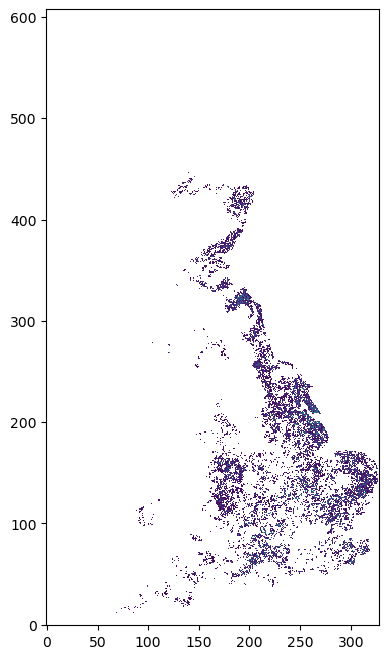

In [9]:
plt.figure(figsize=(10,8))
plt.imshow(data.area.sel(Type=list(code_dict.keys())[4]), interpolation='none', origin='lower')

In [10]:
encoding = {"area":{"dtype":"float32", "zlib": True, "complevel": 5}}
data.to_netcdf(f"data/UKCEH_LCPCP_{resolution}.nc", encoding=encoding)